In [7]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

import desc
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_3d,plot_comparison, plot_section, plot_fsa, plot_surfaces, plot_grid
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid
from desc.profiles import PowerSeriesProfile

from desc.backend import jnp
from desc.compute import get_params, get_profiles, get_transforms
from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives.normalization import compute_scaling_factors
from desc.magnetic_fields._core import biot_savart_general

In [2]:
eq = get("precise_QA")
# eq.pressure = 0
# eq.solve();

160801 5
401 220 220
(5, 3)


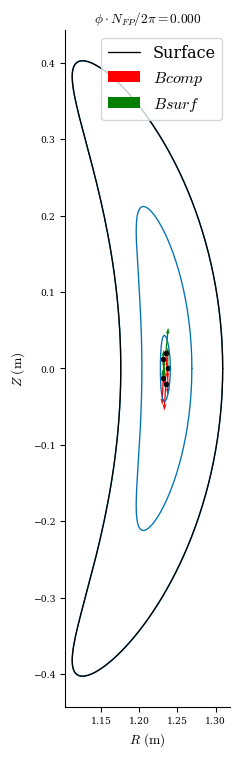

In [8]:
grid_source = LinearGrid(rho=1, M=200, N=200, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=0.05, M=2, N=0, NFP=int(eq.NFP))
print(grid_source.num_nodes, grid_eval.num_nodes)

keys = [
    "K_vc",
    "B",
    "|B|^2",
    "|B|",
    "R",
    "phi",
    "Z",
    "e^rho",
    "n_rho",
    "|e_theta x e_zeta|",
    "p",
    "e^theta"
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)
K_source = data_source["K_vc"]

k = min(grid_source.num_theta, grid_source.num_zeta)
s = k // 2 + int(np.sqrt(k))
q = k // 2 + int(np.sqrt(k))
print(k, s, q)

Bplasma = _nonsingular_part(
        data_eval, grid_eval, data_source, grid_source, s, kernel=kernels["biot_savart"],
    )
# Bplasma += data_eval["B"]
# Bplasma *= -1
print(Bplasma.shape)

scale = 2
fig,ax = plot_surfaces(eq,theta=0,rho=np.array([0.1, 0.5, 1.0]), phi=0.0, figsize=(8,8),label="Surface",lcfs_color="k")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$Bcomp$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$Bsurf$",scale=scale,color="g")
ax[0].scatter(data_eval["R"],data_eval["Z"],color="k", s=10)
ax[0].legend(fontsize=12)
fig=plt.gcf()
# plt.savefig("precise_QA_r_0.1.png",dpi=500)
plt.savefig("precise_QA_test.png",dpi=500)


# plt.figure()
# mag_Bplasma = np.linalg.norm(Bplasma,axis=1)
# plt.plot(mag_Bplasma, label="|B| surface integral")
# plt.plot(data_eval["|B|"], label="|B| original")
# plt.legend()

2401 9


/home/yigit/Codes/DESC/desc/utils.py:495: FutureWarning: argument zeta has been renamed to phi, zeta will be removed in a future release
  warnings.warn(


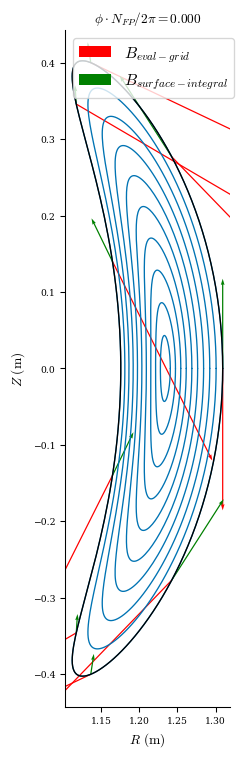

In [15]:
grid_source = LinearGrid(rho=1, M=24, N=24, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=1, M=4, N=0, NFP=int(eq.NFP))
print(grid_source.num_nodes, grid_eval.num_nodes)

keys = [
    "K_vc",
    "B",
    "|B|^2",
    "R",
    "phi",
    "Z",
    "e^rho",
    "n_rho",
    "|e_theta x e_zeta|",
    "p",
    "e^theta"
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)
K_source = data_source["K_vc"]

k = min(grid_source.num_theta, grid_source.num_zeta)
s = k // 2 + int(np.sqrt(k))
q = k // 2 + int(np.sqrt(k))

interpolator = FFTInterpolator(grid_eval, grid_source, s, q)

Bplasma = _singular_part(data_eval, grid_eval, data_source, grid_source, s, q, kernels["biot_savart"], interpolator, loop=False)
Bplasma += _nonsingular_part(data_eval, grid_eval, data_source, grid_source, s, kernel=kernels["biot_savart"])
Bplasma += data_eval["B"]/2
# Bplasma *= 2

scale = 0.3
fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1), zeta=0.0,figsize=(8,8),lcfs_color="k")
# ax[0].quiver(data_source["R"],data_source["Z"],data_source["B"][:,0],data_source["B"][:,2],label=r"$B_{original}$",scale=scale,color="b")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].legend(fontsize=12)
fig=plt.gcf()

In [14]:
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz
from desc.backend import fori_loop

grid_source = LinearGrid(rho=1, M=24, N=24, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=0.5, M=4, N=0, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "B",
    "|B|^2",
    "R",
    "phi",
    "Z",
    "e^rho",
    "n_rho",
    "|e_theta x e_zeta|",
    "p",
    "e^theta"
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)

# surface element, must divide by NFP to remove the NFP multiple on the
# surface grid weights, as we account for that when doing the for loop
# over NFP
_dV = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
coord = rpz2xyz_vec(grid_eval.nodes),
r_source = rpz2xyz_vec(grid_source.nodes),
K = rpz2xyz_vec(data_source["K_vc"]),
def nfp_loop(j, f):
    # calculate (by rotating) rs, rs_t, rz_t
    phi = (grid_source.nodes[:, 2] + j * 2 * jnp.pi / grid_source.NFP) % (
        2 * jnp.pi
    )
    fj = biot_savart_general(
        rpz2xyz_vec(grid_eval.nodes),
        rpz2xyz_vec(grid_source.nodes),
        rpz2xyz_vec(data_source["K_vc"]),
        _dV,
    )
    f += fj
    return f

Bplasma = fori_loop(0, grid_source.NFP, nfp_loop, jnp.zeros_like(grid_eval.nodes))

fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1), zeta=0.0,figsize=(8,8),lcfs_color="k")
# ax[0].quiver(data_source["R"],data_source["Z"],data_source["B"][:,0],data_source["B"][:,2],label=r"$B_{original}$",scale=scale,color="b")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].legend(fontsize=12)
fig=plt.gcf()

TypeError: cos requires ndarray or scalar arguments, got <class 'NoneType'> at position 0.